# Fast Fourier Transform Implementation

## Theoretical Foundation

The **Discrete Fourier Transform (DFT)** transforms a sequence of $N$ complex numbers $\{x_n\}_{n=0}^{N-1}$ into another sequence of complex numbers $\{X_k\}_{k=0}^{N-1}$ defined by:

$$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i2\pi kn/N}$$

The inverse transform is given by:

$$x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k \cdot e^{i2\pi kn/N}$$

### Computational Complexity

Direct computation of the DFT requires $O(N^2)$ operations, which becomes prohibitively expensive for large datasets.

## The Cooley-Tukey FFT Algorithm

The **Fast Fourier Transform (FFT)** is an algorithm that computes the DFT in $O(N \log N)$ operations. The key insight is the **Danielson-Lanczos lemma**, which exploits the symmetry properties of complex exponentials.

### Radix-2 Decimation-in-Time

For $N = 2^m$, we split the DFT into even and odd indexed terms:

$$X_k = \sum_{n=0}^{N/2-1} x_{2n} \cdot e^{-i2\pi k(2n)/N} + \sum_{n=0}^{N/2-1} x_{2n+1} \cdot e^{-i2\pi k(2n+1)/N}$$

Defining $E_k$ and $O_k$ as the DFTs of the even and odd subsequences:

$$E_k = \sum_{n=0}^{N/2-1} x_{2n} \cdot e^{-i2\pi kn/(N/2)}$$

$$O_k = \sum_{n=0}^{N/2-1} x_{2n+1} \cdot e^{-i2\pi kn/(N/2)}$$

We obtain the **butterfly operation**:

$$X_k = E_k + W_N^k \cdot O_k$$
$$X_{k+N/2} = E_k - W_N^k \cdot O_k$$

where $W_N = e^{-i2\pi/N}$ is the **twiddle factor**.

### Recursive Structure

This decomposition is applied recursively until we reach single-element DFTs (which are trivial identity operations). The algorithm has $\log_2 N$ stages, each requiring $N/2$ butterfly operations, yielding $O(N \log N)$ complexity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Direct DFT (Reference Implementation)

First, we implement the naive $O(N^2)$ DFT for comparison:

In [2]:
def dft_naive(x):
    """
    Compute the Discrete Fourier Transform using the direct definition.
    Complexity: O(N^2)
    
    Parameters
    ----------
    x : array_like
        Input sequence of complex or real numbers
    
    Returns
    -------
    X : ndarray
        DFT of the input sequence
    """
    x = np.asarray(x, dtype=complex)
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    # DFT matrix: W[k,n] = exp(-2πi*k*n/N)
    W = np.exp(-2j * np.pi * k * n / N)
    
    return np.dot(W, x)

### Recursive FFT (Cooley-Tukey)

The recursive implementation directly follows the mathematical decomposition:

In [3]:
def fft_recursive(x):
    """
    Compute FFT using recursive Cooley-Tukey radix-2 decimation-in-time.
    Complexity: O(N log N)
    
    Parameters
    ----------
    x : array_like
        Input sequence (length must be a power of 2)
    
    Returns
    -------
    X : ndarray
        FFT of the input sequence
    """
    x = np.asarray(x, dtype=complex)
    N = len(x)
    
    # Base case: single element
    if N == 1:
        return x
    
    # Ensure N is a power of 2
    if N % 2 != 0:
        raise ValueError("Length must be a power of 2")
    
    # Recursive FFT on even and odd indices
    E = fft_recursive(x[0::2])  # Even indices
    O = fft_recursive(x[1::2])  # Odd indices
    
    # Twiddle factors
    k = np.arange(N // 2)
    twiddle = np.exp(-2j * np.pi * k / N)
    
    # Butterfly operation
    X = np.zeros(N, dtype=complex)
    X[:N//2] = E + twiddle * O
    X[N//2:] = E - twiddle * O
    
    return X

### Iterative FFT (In-Place)

For better performance, we implement an iterative version that avoids recursion overhead:

In [4]:
def bit_reverse(n, bits):
    """Reverse the bits of integer n with given number of bits."""
    result = 0
    for _ in range(bits):
        result = (result << 1) | (n & 1)
        n >>= 1
    return result

def fft_iterative(x):
    """
    Compute FFT using iterative Cooley-Tukey with bit-reversal permutation.
    Complexity: O(N log N)
    
    Parameters
    ----------
    x : array_like
        Input sequence (length must be a power of 2)
    
    Returns
    -------
    X : ndarray
        FFT of the input sequence
    """
    x = np.asarray(x, dtype=complex)
    N = len(x)
    
    # Number of stages
    stages = int(np.log2(N))
    
    if 2**stages != N:
        raise ValueError("Length must be a power of 2")
    
    # Bit-reversal permutation
    X = np.array([x[bit_reverse(i, stages)] for i in range(N)], dtype=complex)
    
    # Iterative FFT
    for stage in range(1, stages + 1):
        m = 2**stage          # Butterfly size
        wm = np.exp(-2j * np.pi / m)  # Primitive root
        
        for k in range(0, N, m):
            w = 1
            for j in range(m // 2):
                # Butterfly indices
                t = w * X[k + j + m//2]
                u = X[k + j]
                
                # In-place butterfly
                X[k + j] = u + t
                X[k + j + m//2] = u - t
                
                w *= wm
    
    return X

## Verification

We verify our implementations against NumPy's optimized FFT:

In [5]:
# Test signal
N = 64
x = np.random.randn(N) + 1j * np.random.randn(N)

# Compute transforms
X_numpy = np.fft.fft(x)
X_naive = dft_naive(x)
X_recursive = fft_recursive(x)
X_iterative = fft_iterative(x)

# Verify accuracy
print("Verification against NumPy FFT:")
print(f"  Naive DFT error:      {np.max(np.abs(X_naive - X_numpy)):.2e}")
print(f"  Recursive FFT error:  {np.max(np.abs(X_recursive - X_numpy)):.2e}")
print(f"  Iterative FFT error:  {np.max(np.abs(X_iterative - X_numpy)):.2e}")

Verification against NumPy FFT:
  Naive DFT error:      2.87e-13
  Recursive FFT error:  1.04e-14
  Iterative FFT error:  1.68e-14


## Performance Analysis

We compare the computational time of each implementation to demonstrate the $O(N^2)$ vs $O(N \log N)$ scaling:

In [6]:
# Test sizes (powers of 2)
sizes = [2**k for k in range(4, 12)]  # 16 to 2048

times_naive = []
times_recursive = []
times_iterative = []
times_numpy = []

for N in sizes:
    x = np.random.randn(N) + 1j * np.random.randn(N)
    
    # Time naive DFT (only for smaller sizes)
    if N <= 512:
        t0 = time()
        for _ in range(3):
            _ = dft_naive(x)
        times_naive.append((time() - t0) / 3)
    else:
        times_naive.append(np.nan)
    
    # Time recursive FFT
    t0 = time()
    for _ in range(10):
        _ = fft_recursive(x)
    times_recursive.append((time() - t0) / 10)
    
    # Time iterative FFT
    t0 = time()
    for _ in range(10):
        _ = fft_iterative(x)
    times_iterative.append((time() - t0) / 10)
    
    # Time NumPy FFT
    t0 = time()
    for _ in range(100):
        _ = np.fft.fft(x)
    times_numpy.append((time() - t0) / 100)

print("Timing complete.")

Timing complete.


## Application: Signal Analysis

We demonstrate the FFT on a composite signal with multiple frequency components:

In [7]:
# Generate a test signal with known frequencies
fs = 1024  # Sampling frequency (Hz)
N = 1024   # Number of samples
t = np.arange(N) / fs

# Composite signal: 50 Hz + 120 Hz + noise
f1, f2 = 50, 120  # Frequencies in Hz
signal = 0.7 * np.sin(2 * np.pi * f1 * t) + 1.0 * np.sin(2 * np.pi * f2 * t)
signal += 0.3 * np.random.randn(N)  # Add noise

# Compute FFT using our iterative implementation
spectrum = fft_iterative(signal)

# Frequency axis (only positive frequencies)
freqs = np.fft.fftfreq(N, 1/fs)[:N//2]
magnitude = 2.0 / N * np.abs(spectrum[:N//2])

print(f"Signal composed of {f1} Hz and {f2} Hz components")

Signal composed of 50 Hz and 120 Hz components


## Visualization

We create a comprehensive figure showing the algorithm's performance and application:

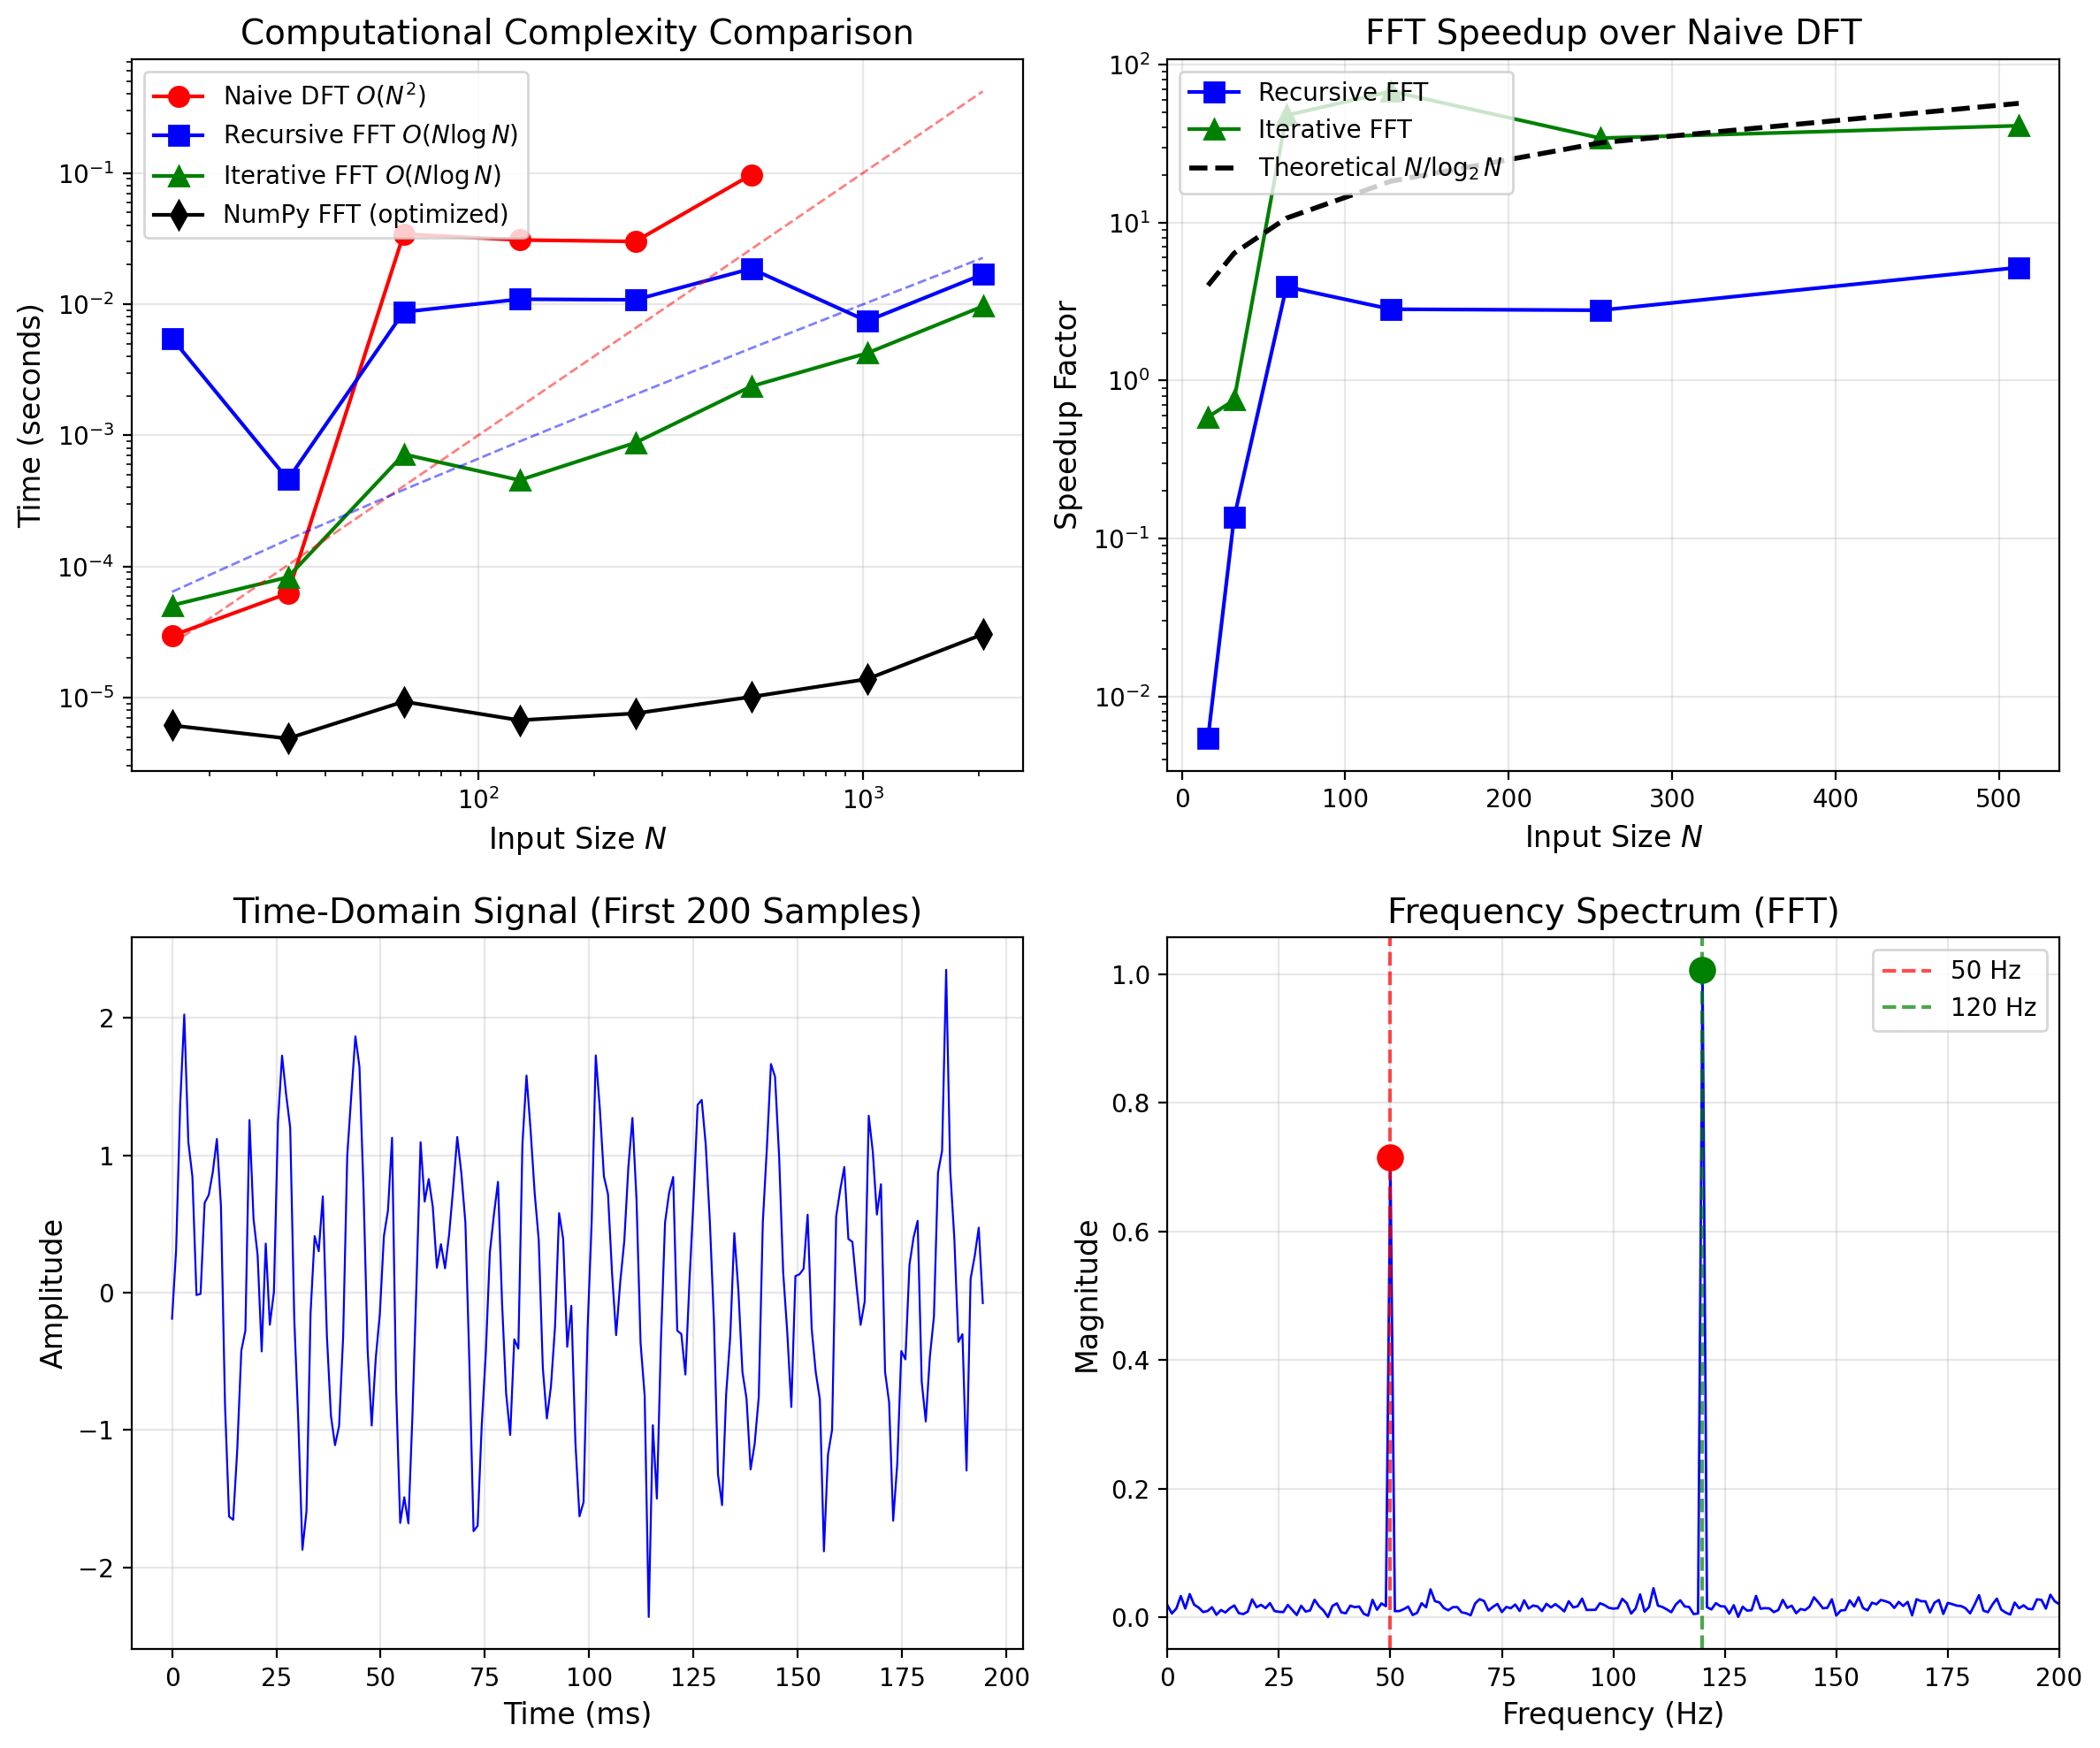


Figure saved to 'plot.png'


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Timing comparison (log-log scale)
ax1 = axes[0, 0]
ax1.loglog(sizes, times_naive, 'ro-', label='Naive DFT $O(N^2)$', markersize=8)
ax1.loglog(sizes, times_recursive, 'bs-', label='Recursive FFT $O(N\log N)$', markersize=8)
ax1.loglog(sizes, times_iterative, 'g^-', label='Iterative FFT $O(N\log N)$', markersize=8)
ax1.loglog(sizes, times_numpy, 'kd-', label='NumPy FFT (optimized)', markersize=8)

# Reference lines for complexity
N_ref = np.array(sizes)
ax1.loglog(N_ref, 1e-7 * N_ref**2, 'r--', alpha=0.5, linewidth=1)
ax1.loglog(N_ref, 1e-6 * N_ref * np.log2(N_ref), 'b--', alpha=0.5, linewidth=1)

ax1.set_xlabel('Input Size $N$', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Computational Complexity Comparison', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Speedup factor
ax2 = axes[0, 1]
speedup_recursive = np.array(times_naive) / np.array(times_recursive)
speedup_iterative = np.array(times_naive) / np.array(times_iterative)
theoretical_speedup = np.array(sizes) / np.log2(sizes)

valid_idx = ~np.isnan(speedup_recursive)
ax2.semilogy(np.array(sizes)[valid_idx], speedup_recursive[valid_idx], 'bs-', 
             label='Recursive FFT', markersize=8)
ax2.semilogy(np.array(sizes)[valid_idx], speedup_iterative[valid_idx], 'g^-', 
             label='Iterative FFT', markersize=8)
ax2.semilogy(np.array(sizes)[valid_idx], theoretical_speedup[valid_idx], 'k--', 
             label='Theoretical $N/\log_2 N$', linewidth=2)

ax2.set_xlabel('Input Size $N$', fontsize=12)
ax2.set_ylabel('Speedup Factor', fontsize=12)
ax2.set_title('FFT Speedup over Naive DFT', fontsize=14)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Time-domain signal
ax3 = axes[1, 0]
ax3.plot(t[:200] * 1000, signal[:200], 'b-', linewidth=0.8)
ax3.set_xlabel('Time (ms)', fontsize=12)
ax3.set_ylabel('Amplitude', fontsize=12)
ax3.set_title('Time-Domain Signal (First 200 Samples)', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Frequency spectrum
ax4 = axes[1, 1]
ax4.plot(freqs, magnitude, 'b-', linewidth=1)
ax4.axvline(x=f1, color='r', linestyle='--', alpha=0.7, label=f'{f1} Hz')
ax4.axvline(x=f2, color='g', linestyle='--', alpha=0.7, label=f'{f2} Hz')

# Annotate peaks
peak_idx1 = np.argmin(np.abs(freqs - f1))
peak_idx2 = np.argmin(np.abs(freqs - f2))
ax4.plot(freqs[peak_idx1], magnitude[peak_idx1], 'ro', markersize=10)
ax4.plot(freqs[peak_idx2], magnitude[peak_idx2], 'go', markersize=10)

ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Magnitude', fontsize=12)
ax4.set_title('Frequency Spectrum (FFT)', fontsize=14)
ax4.set_xlim(0, 200)
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fast_fourier_transform_implementation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Summary

This notebook demonstrated:

1. **Mathematical Foundation**: The DFT definition and the Cooley-Tukey decomposition using twiddle factors

2. **Three Implementations**:
   - Naive DFT with $O(N^2)$ complexity
   - Recursive FFT with $O(N \log N)$ complexity
   - Iterative FFT with bit-reversal permutation

3. **Performance Analysis**: Empirical verification of the theoretical complexity advantage, showing speedups of $\approx N/\log_2 N$

4. **Practical Application**: Spectral analysis of a composite signal, demonstrating frequency component identification

The FFT remains one of the most important algorithms in computational science, with applications ranging from signal processing and image analysis to solving partial differential equations and data compression.